# Quora question pairs: training

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)


## Initialize global variables

In [2]:


path = '/home/ubuntu/quora/'
data_home = path +"data/"

Q1_TRAINING_DATA_FILE = data_home+'cache/q1_train.npy'
Q2_TRAINING_DATA_FILE = data_home+'cache/q2_train.npy'
LABEL_TRAINING_DATA_FILE = data_home+'cache/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = data_home+'cache/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = data_home+'cache/nb_words.json'
Q1_TESTING_DATA_FILE = 'q1_test.npy'
Q2_TESTING_DATA_FILE = 'q2_test.npy'


MODEL_WEIGHTS_FILE = path+'weights/brad_weights_v1.h5'
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25

## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [4]:
q1_data.shape,q2_data.shape

((404290, 35), (404290, 35))

## Partition the dataset into train and test sets

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=2019)


In [6]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
# Q1_train = X_train[:,0]
# Q2_train = X_train[:,1]
# Q1_test = X_test[:,0]
# Q2_test = X_test[:,1]

In [7]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



TRAIN: [337176  17039  75113 ...,  41001 336218 115328] TEST: [283851 377233  35357 ..., 392228 325350 150065]


In [8]:
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [17]:
Q1 = Sequential()
Q1.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))
Q1.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q1.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))


Q2 = Sequential()
Q2.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))
Q2.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))


model = Sequential()
model.add(Merge([Q1, Q2], mode='concat'))
# concat = Concatenate([Q1, Q2])
# model.add(concat)

model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])#, 'precision', 'recall', 'fbeta_score'])

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


## Train the model, checkpointing weights with best validation accuracy

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-04-25 09:17:31.416546


## Plot training and validation accuracy

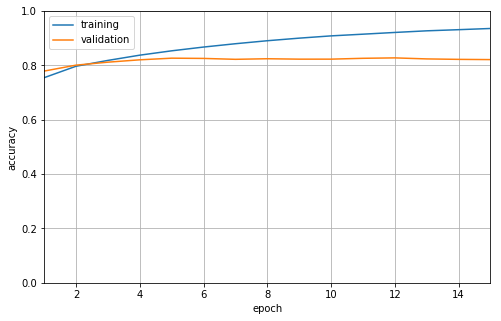

In [62]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

without cleaning: Maximum accuracy at epoch 8 = 0.8227
with cleaning: Maximum accuracy at epoch 15 = 0.8268
with cleaning and stratified: 0.8275

In [63]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 12 = 0.8275


## Evaluate the model with best validation accuracy on the test partition

In [8]:
model.load_weights(MODEL_WEIGHTS_FILE)


In [7]:
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test) #, precision, recall, fbeta_score
print('')
print('loss      = {0:.4f}'.format(loss))
print('accuracy  = {0:.4f}'.format(accuracy))
# print('precision = {0:.4f}'.format(precision))
# print('recall    = {0:.4f}'.format(recall))
# print('F         = {0:.4f}'.format(fbeta_score))

NameError: name 'Q1_test' is not defined

In [66]:
preds = model.predict([Q1_test, Q2_test])



In [68]:
from sklearn.metrics import log_loss

print (log_loss(y_test,preds))
print (log_loss(y_test,np.clip(preds,1-0.82,0.82)))
print (log_loss(y_test,np.clip(preds,1-0.90,0.90)))
print (log_loss(y_test,np.clip(preds,1-0.899,0.899)))




0.4424577076
0.429822795845
0.408509283647
0.40864156197


## Making predictions on test set

In [9]:
q1_test_data = np.load(open(data_home+"cache/"+Q1_TESTING_DATA_FILE, 'rb'))
q2_test_data = np.load(open(data_home+"cache/"+Q2_TESTING_DATA_FILE, 'rb'))

In [10]:
q1_test_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    5,   22,    1, 1990,  802, 1222,   13,  352,   29,
       1611,  802], dtype=int32)

In [11]:
preds = model.predict([q1_test_data,q2_test_data], batch_size=128)

In [12]:
preds.shape

(2345796, 1)

In [13]:
clip =0.90

submission_name = "subm/brad_preproc_stratified_1_c90.csv"
flattend = preds.flatten()

clipped = np.clip(flattend,1-clip,clip)

In [14]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': clipped})
sub.head(2)

,is_duplicate,test_id
0,0.100000,0
1,0.300878,1


In [15]:
sub.to_csv(path+submission_name, index=False)

In [17]:
from IPython.lib.display import FileLink

FileLink(submission_name)

/home/ubuntu/quora/subm/brad_preproc_stratified_1_c90.csv